# 03-04 - Ensembles and Statistical Inference

*May 8 2024*  

In the last notebook of this week, we implement a method to calculate the likelihood of model parameters for the $G(n,p)$ random graph model and use it to obtain a maximum likelihood estimate of model parameters for empirical networks. This admittedly simple example illustrates the statistical inference approach, which we will further develop to detect community structures in a generalized $G(n,p)$ model.

In [1]:
import pathpy as pp
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

plt.style.use('default')
sns.set_style("whitegrid")
    
from numpy import linalg as npl
import scipy as sp

import scipy.special
from collections import Counter

We start with our toy example network from the lecture:

In [3]:
n = pp.Network(directed=False)
n.add_edge('a', 'b')
n.add_edge('b', 'c')
n.add_edge('a', 'c')
n.add_edge('b', 'd')
n.add_edge('d', 'f')
n.add_edge('d', 'e')
n.add_edge('e', 'f')
n.add_edge('d', 'g')
n.add_edge('f', 'g')
n.plot(edge_color='grey')

The following function calculates the likelihood of the $G(n,p)$ model given the number of nodes and links in a microstate:

In [4]:
def Gnp_likelihood(p, network: pp.Network):
    return p**network.number_of_edges() * (1-p)**(scipy.special.binom(network.number_of_nodes(), 2)-network.number_of_edges())

In [5]:
Gnp_likelihood(0.1, n)

2.824295364810002e-10

In [6]:
Gnp_likelihood(1, n)

0.0

In [7]:
Gnp_likelihood(0, n)

0.0

In the lecture, we have seen that the obtained maximum likelihood estimate $\hat{p}$ corresponds to 

$$ \frac{m}{\binom{n}{2}} $$

You will calculate this in the exercise sheet. The following function calculates the maximum likelihood estimate $\hat{p}$ for an empirical network.

In [8]:
def Gnp_MLE(network: pp.Network):
    return network.number_of_edges() / scipy.special.binom(network.number_of_nodes(), 2)

In [9]:
Gnp_MLE(n)

0.42857142857142855

Let us visually confirm that this value corresponds to the maximum likelihood. We plot the likelihood as a function of $p$ and mark our estimate with a red vertical line. 

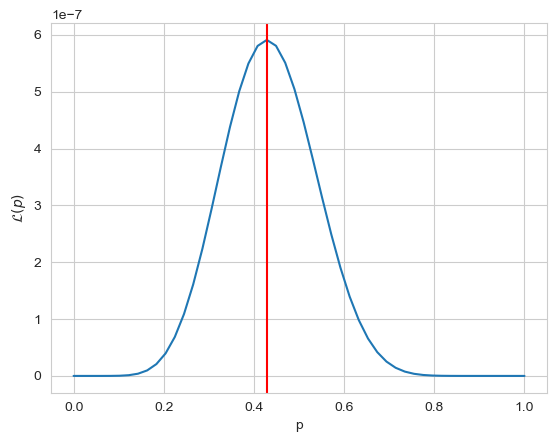

In [12]:
p = np.linspace(0, 1, num=50)
ax = plt.plot(p, Gnp_likelihood(p, n))
plt.xlabel('p')
plt.ylabel(r'$\mathcal{L}(p)$')
plt.axvline(x=Gnp_MLE(n), color='red')

The size of a statistical ensemble of networks quickly grows as we increase the number of nodes. It is thus often reasonable to calculate the likelihood in logarithmic space. The following function calculates the log-likelihood of model parameters:

In [13]:
def Gnp_log_likelihood(p, network: pp.Network):
    return network.number_of_edges()*np.log10(p) + (scipy.special.binom(network.number_of_nodes(), 2)-network.number_of_edges()) * np.log10(1-p)

In [17]:
n_highschool = pp.io.sql.read_network('../week01/data/networks.db', sql='SELECT source, target FROM highschool',directed=False)
print(n_highschool)
n_highschool.plot(edge_color='grey')

[05-18 11:17:25: WARNING] 154 edges existed already and were not be considered. To capture those edges, consider creating a multiedge and/or directed network.


Uid:			0x19bec7c76a0
Type:			Network
Directed:		False
Multi-Edges:		False
Number of nodes:	120
Number of edges:	348


We find that the likelihood is extremely small, which is due to the very small probability of this specific microstate in the huge ensemble. 

In [11]:
Gnp_log_likelihood(Gnp_MLE(n_highschool), n_highschool)

-604.0074314022678

Let us generate a random realization based on the $G(n,m)$ model and compare the log-likelihood of the model parameters for this realization to the log-likelihood of the actual empirical network.

In [18]:
n_highschool_r = pp.generators.ER_nm_randomize(n_highschool)
Gnp_log_likelihood(Gnp_MLE(n_highschool), n_highschool_r)

-604.0074314022678

We find that the likelihoods (and thus microstate probabilities) are identical, which should not surprise us since the likelihood is only based on the number of nodes and links in the observed network. However, if we compare the two networks, the random realization would still appear more characteristic of a $G(n,p)$ random graph model compared to the empirical network. 

However, this is an illusion, because the microstate probability of one *specific* random realization is as small as the microstate probability of the *specific empirical* network that we observed. What we may suspect though, is that the degree distribution of the random realization may be more characteristic of a random graph compared to that of the empirical network. To quantify this, we can compute the likelihood of the model based on the observed degree sequence rather than based on the observed number of nodes and links. For this, we use the degree distribution of the $G(n,p)$ model that we calculated in the lecture.

In [19]:
def Gnp_degree_log_likelihood(p, network: pp.Network):
    l = 0
    for k in network.degree_sequence():
        l += np.log10(scipy.special.binom(network.number_of_nodes(), k)) + k * np.log10(p) + (network.number_of_nodes()-k) * np.log(1-p)
    return l

In [20]:
Gnp_degree_log_likelihood(Gnp_MLE(n_highschool), n_highschool)

-506.47460235056315

In [21]:
Gnp_degree_log_likelihood(Gnp_MLE(n_highschool_r), n_highschool_r)

-506.02992953378873

We first observe that the likelihood is now approx. 100 orders of magnitude larger, which is due to the fact that we now calculate it based on the probability to observe a microstate with a given degree sequence rather than one specific network topology. Since there are many different networks with the same degree sequence, this likelihood will be much larger.

We do observe a difference between the likelihoods but it is not very large. So it seems that the degree sequence of the empirical network is not much different from what we could expect from a random graph model.

This is very different for the Gentoo collaboration network, where we observe a broad degree distribution.

In [22]:
n_gentoo = pp.io.sql.read_network('../week01/data/networks.db', sql='SELECT source, target FROM gentoo', directed=False)
print(n_gentoo)
n_gentoo.plot()

Uid:			0x19bec96e5e0
Type:			Network
Directed:		False
Multi-Edges:		False
Number of nodes:	403
Number of edges:	513


Again, if we compare the likelihood of model parameters for the empirical network with that of a randomly generated network, we get the same value although both will look very different.

In [23]:
Gnp_log_likelihood(Gnp_MLE(n_gentoo), n_gentoo)

-1349.8569477477868

In [24]:
n_gentoo_r = pp.generators.ER_nm_randomize(n_gentoo)
print(n_gentoo_r)
Gnp_log_likelihood(Gnp_MLE(n_gentoo_r), n_gentoo_r)

Uid:			0x19bec88fa60
Type:			Network
Directed:		False
Multi-Edges:		False
Number of nodes:	403
Number of edges:	513


-1349.8569477477868

A comparison of the degree-based likelihood confirms that the degree sequence of the randomly generated network is much more characteristic for a $G(n,p)$ random graph than the degree sequence of the empirical network. We thus find a difference in likelihood of more than 300 orders of magnitude!

In [19]:
Gnp_degree_log_likelihood(Gnp_MLE(n_gentoo), n_gentoo)

-1359.3123496318583

In [20]:
Gnp_degree_log_likelihood(Gnp_MLE(n_gentoo_r), n_gentoo_r)

-903.1162701916933